## DS 862 Machine Learning for Business Analysts Fall 2020

### Dimension Reduction Techniques

#### Submitted by:
* Di Wang

For this assignment, we will use another digit data set, since it only consists of numerical features. Your job is to apply the dimension reduction technique we learned, and combined with the classification methods you learned from DS861, to build a classifier. 

In [1]:
# Import general libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pylab as pl 
import warnings # Suppress warnings because they are annoying
warnings.filterwarnings('ignore')
import time #Help you deal with running time

In [2]:
# Import the data

# The targets are number 0-9, store in the data
from sklearn.datasets import load_digits
X_digits, y_digits = load_digits(return_X_y = True)
digits = load_digits()
print(digits.data.shape)

(1797, 64)


<Figure size 432x288 with 0 Axes>

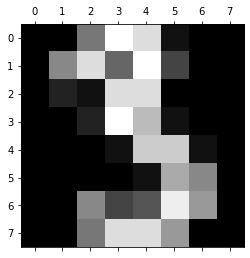

In [3]:
# Understand the dataset by plotting a number "3"

pl.gray() 
pl.matshow(digits.images[3]) 
pl.show() 

In [4]:
# Split data into training and testing sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state = 862)

In [5]:
# It has 1347 rows and 8*8 64 columns for train dataset
X_train.shape

(1347, 64)

Here you will build your classifier with the appropriate dimension reduction technique and classification model. Recall that we have learned the following classifiers in DS861: Logistic Regression, Decision Tree, Random Forest, Boosting, KNN. This data set is a multi-level data set, hence you should think about which model is appropriate (or not appropriate). To save time, you may just pick two estimators that you think is the most appropriate and compare.

Some general rules you should follow:

1. Tune your dimension reduction technique
2. Tune your model
3. Select your hyperparameters based on a hold-out set (either via CV or train/validate/test split)
4. Report the accuracy on the test set

You may ignore randomized PCA and incremental PCA, since they don't have added value here. We will not use MDS and t-SNE here as well since they cannot be used to transform new observations. If you want to write a wrapper that contains multiple classifiers, [here](https://stackoverflow.com/questions/50285973/pipeline-multiple-classifiers) or [here](https://stackoverflow.com/questions/38555650/try-multiple-estimator-in-one-grid-search) have some good examples.

### Model selection

The link below shows a research paper related to this assignment.

[Comparison of Machine Learning Algorithms for Raw Handwritten Digits Recognition](https://ieeexplore-ieee-org.jpllnet.sfsu.edu/document/8645138)

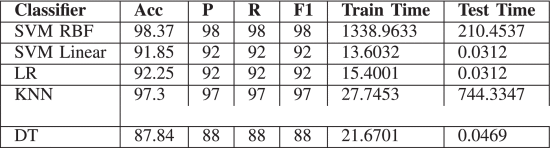

Based on their research result, I would like to use Logistic Regression and KNN Models for the following tasks.

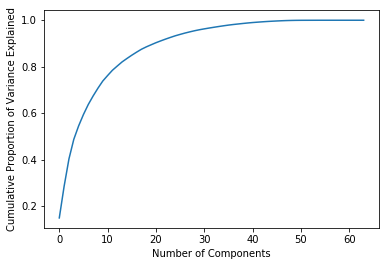

In [6]:
from sklearn.decomposition import PCA

# Fit the PCA
pca = PCA().fit(X_digits)

# Plot the scree plot
plt.plot(range(0, 64), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.show()
# Number of components is what you see in the graph +1 ! (we could easily solve this)

In order to cover around 90% variability, we will use 20 components for this study.

#### Model 1: Sparse PCA + Logistic Regression

In [7]:
# We Sparse PCA first

from sklearn.decomposition import SparsePCA

# Tunning this method with Logistic Regression model

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

start = time.time()

clf1 = Pipeline([
        ("spca", SparsePCA(n_components=20, n_jobs = -1)),
        ("log_reg", LogisticRegression(solver="newton-cg")) 
    ])

param_grid1 = [{
        "spca__method": ["lars", "cd"], #least angle regression or coordinate descent method
        "spca__max_iter":[50,100],
        "log_reg__C": [0.1, 1, 5, 10]
    }]

grid_search1 = RandomizedSearchCV(clf1, param_grid1, cv=5)
grid_search1.fit(X_train, y_train)
print(grid_search1.best_params_)

{'spca__method': 'lars', 'spca__max_iter': 100, 'log_reg__C': 0.1}


In [8]:
# Get accuracy score, f1 score, and time spend to run the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

y_hat1 = grid_search1.predict(X_test)

accuracy1 = accuracy_score(y_test, y_hat1)
print("The accuracy score for Model 1 is: "+ str(accuracy1))

f1score1 = f1_score(y_test, y_hat1, average='macro')
print("The f1 score for Model 1 is: "+ str(f1score1))

end = time.time()
time1=end-start
print("Total time we use is: "+str(time1))

The accuracy score for Model 1 is: 0.9488888888888889
The f1 score for Model 1 is: 0.9484996132162195
Total time we use is: 294.8480956554413


#### Model 2: Sparse PCA + KNN

In [9]:
from sklearn import neighbors, metrics # The KNN function sits inside the neighbors subpackage of sklearn

start = time.time()

clf2 = Pipeline([
        ("spca", SparsePCA(n_components=20, n_jobs = -1)),
        ("knn", neighbors.KNeighborsClassifier(weights='uniform'))
    ])

param_grid2 = [{
        "spca__method": ["lars", "cd"], #least angle regression or coordinate descent method
        "spca__max_iter":[50, 100],
        "knn__n_neighbors": [2, 4, 8, 16]
    }]

grid_search2 = RandomizedSearchCV(clf2, param_grid2, cv=5)
grid_search2.fit(X_train, y_train)
print(grid_search2.best_params_)

{'spca__method': 'lars', 'spca__max_iter': 50, 'knn__n_neighbors': 2}


In [10]:
# Get accuracy score, f1 score, and time spend to run the model

y_hat2 = grid_search2.predict(X_test)

accuracy2 = accuracy_score(y_test, y_hat2)
print("The accuracy score for Model 2 is: "+ str(accuracy2))

f1score2 = f1_score(y_test, y_hat2, average='macro')
print("The f1 score for Model 2 is: "+ str(f1score2))

end = time.time()
time2=end-start
print("Total time we use is: "+str(time2))

The accuracy score for Model 2 is: 0.9711111111111111
The f1 score for Model 2 is: 0.969412514247829
Total time we use is: 265.0005714893341


#### Model 3: Kernel PCA + Logistic Regression

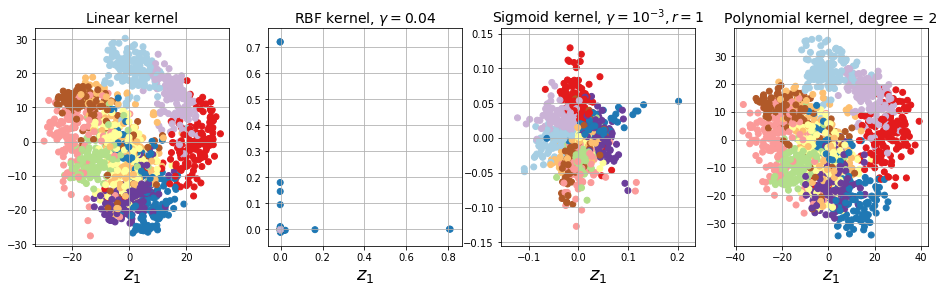

In [11]:
# We use Kernel PCA this time
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 20, kernel="linear", fit_inverse_transform=True) # Traditional PCA
rbf_pca = KernelPCA(n_components = 20, kernel="rbf", gamma=0.04, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 20, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)
poly_pca = KernelPCA(n_components = 20, kernel='poly', degree = 2, fit_inverse_transform=True)

# Let's plot the 2 PCs for each kernel PCA result
plt.figure(figsize=(16, 4))
titles = ["Linear kernel", "RBF kernel, $\gamma=0.04$", "Sigmoid kernel, $\gamma=10^{-3}, r=1$", "Polynomial kernel, degree = 2"]
for subplot, title, pca in zip((141, 142, 143, 144), titles,
                                     (lin_pca, rbf_pca, sig_pca, poly_pca)):

    X_reduced = pca.fit_transform(X_train) # Transform data
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train, cmap="Paired")
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

It looks like Linear kernel and Polynomial kernel are doing a better job than RBF kernel and Sigmoid kernel. We will test it in the following part.

In [12]:
# Tune the Hyper-Parameter

start = time.time()

clf3 = Pipeline([
        ("kpca", KernelPCA(n_components=20, random_state = 862, n_jobs = -1)),
        ("log_reg", LogisticRegression(solver="newton-cg"))
    ])

param_grid3 = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["linear", "rbf", "sigmoid", 'poly'],
        "log_reg__C": [0.1, 1, 5, 10]
    }]

grid_search3 = RandomizedSearchCV(clf3, param_grid3, cv=5)
grid_search3.fit(X_train, y_train)
print(grid_search3.best_params_)

{'log_reg__C': 0.1, 'kpca__kernel': 'linear', 'kpca__gamma': 0.04555555555555556}


In [13]:
# Get accuracy score, f1 score, and time spend to run the model

y_hat3 = grid_search3.predict(X_test)

accuracy3 = accuracy_score(y_test, y_hat3)
print("The accuracy score for Model 3 is: "+ str(accuracy3))

f1score3 = f1_score(y_test, y_hat3, average='macro')
print("The f1 score for Model 3 is: "+ str(f1score3))

end = time.time()
time3=end-start
print("Total time we use is: "+str(time3))

The accuracy score for Model 3 is: 0.9488888888888889
The f1 score for Model 3 is: 0.9484996132162195
Total time we use is: 41.35416293144226


#### Model 4: Kernel PCA + KNN

In [14]:
# Tune the Hyper-Parameter

start = time.time()

clf4 = Pipeline([
        ("kpca", KernelPCA(n_components=20, random_state = 862, n_jobs = -1)),
        ("knn", neighbors.KNeighborsClassifier(weights='uniform'))
    ])

param_grid4 = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["linear", "rbf", "sigmoid", 'poly'],
        "knn__n_neighbors": [2, 4, 8, 16]
    }]

grid_search4 = RandomizedSearchCV(clf4, param_grid4, cv=5)
grid_search4.fit(X_train, y_train)
print(grid_search4.best_params_)

{'kpca__kernel': 'linear', 'kpca__gamma': 0.04777777777777778, 'knn__n_neighbors': 2}


In [15]:
# Get accuracy score, f1 score, and time spend to run the model

y_hat4 = grid_search4.predict(X_test)

accuracy4 = accuracy_score(y_test, y_hat4)
print("The accuracy score for Model 4 is: "+ str(accuracy4))

f1score4 = f1_score(y_test, y_hat4, average='macro')
print("The f1 score for Model 4 is: "+ str(f1score4))

end = time.time()
time4=end-start
print("Total time we use is: "+str(time4))

The accuracy score for Model 4 is: 0.9688888888888889
The f1 score for Model 4 is: 0.9671981941698803
Total time we use is: 23.252674341201782


#### Model 5: LLE + Logistic Regression

In [16]:
# We use LLE this time
from sklearn.manifold import LocallyLinearEmbedding

start = time.time()

# Tune the Hyper-Parameter
clf5 = Pipeline([
        ("lle", LocallyLinearEmbedding(n_components=20, random_state = 862, n_jobs = -1)),
        ("log_reg", LogisticRegression(solver="newton-cg"))
    ])

param_grid5 = [{
        "lle__n_neighbors": [6, 8, 10],
        "log_reg__C": [0.1, 1, 5, 10]
        
    }]

grid_search5 = RandomizedSearchCV(clf5, param_grid5, cv=5)
grid_search5.fit(X_train, y_train)
print(grid_search5.best_params_)

{'log_reg__C': 5, 'lle__n_neighbors': 6}


In [17]:
# Get accuracy score, f1 score, and time spend to run the model

y_hat5 = grid_search5.predict(X_test)

accuracy5 = accuracy_score(y_test, y_hat5)
print("The accuracy score for Model 5 is: "+ str(accuracy5))

f1score5 = f1_score(y_test, y_hat5, average='macro')
print("The f1 score for Model 5 is: "+ str(f1score5))

end = time.time()
time5=end-start
print("Total time we use is: "+str(time5))

The accuracy score for Model 5 is: 0.9555555555555556
The f1 score for Model 5 is: 0.9535478008581457
Total time we use is: 24.3679940700531


#### Model 6: LLE + KNN

In [18]:
# Tune the Hyper-Parameter

start = time.time()

clf6 = Pipeline([
        ("lle", LocallyLinearEmbedding(n_components=20, random_state = 862, n_jobs = -1)),
        ("knn", neighbors.KNeighborsClassifier(weights='uniform'))
    ])

param_grid6 = [{
        "lle__n_neighbors": [6, 8, 10],
        "knn__n_neighbors": [2, 4, 8, 16]
    }]

grid_search6 = RandomizedSearchCV(clf6, param_grid6, cv=5)
grid_search6.fit(X_train, y_train)
print(grid_search6.best_params_)

{'lle__n_neighbors': 6, 'knn__n_neighbors': 2}


In [19]:
# Get accuracy score, f1 score, and time spend to run the model

y_hat6 = grid_search6.predict(X_test)

accuracy6 = accuracy_score(y_test, y_hat6)
print("The accuracy score for Model 6 is: "+ str(accuracy6))

f1score6 = f1_score(y_test, y_hat6, average='macro')
print("The f1 score for Model 6 is: "+ str(f1score6))

end = time.time()
time6=end-start
print("Total time we use is: "+str(time6))

The accuracy score for Model 6 is: 0.9755555555555555
The f1 score for Model 6 is: 0.9746797271181562
Total time we use is: 21.116117000579834


#### Model 7: Isomap + Logistic Regression

In [20]:
# We use Isomap this time
from sklearn.manifold import Isomap

start = time.time()

# Tune the Hyper-Parameter
clf7 = Pipeline([
        ("isomap",Isomap(n_components=20, n_jobs = -1)),
        ("log_reg", LogisticRegression(solver="newton-cg"))
    ])

param_grid7 = [{
        "isomap__n_neighbors": [6, 8, 10],
        "log_reg__C": [0.1, 1, 5, 10]
        
    }]

grid_search7 = RandomizedSearchCV(clf7, param_grid7, cv=5)
grid_search7.fit(X_train, y_train)
print(grid_search7.best_params_)

{'log_reg__C': 0.1, 'isomap__n_neighbors': 8}


In [21]:
# Get accuracy score, f1 score, and time spend to run the model

y_hat7 = grid_search7.predict(X_test)

accuracy7 = accuracy_score(y_test, y_hat7)
print("The accuracy score for Model 7 is: "+ str(accuracy7))

f1score7 = f1_score(y_test, y_hat7, average='macro')
print("The f1 score for Model 7 is: "+ str(f1score7))

end = time.time()
time7=end-start
print("Total time we use is: "+str(time7))

The accuracy score for Model 7 is: 0.9533333333333334
The f1 score for Model 7 is: 0.9523430395354063
Total time we use is: 120.07231545448303


#### Model 8: Isomap + KNN

In [22]:
# Tune the Hyper-Parameter

start = time.time()

clf8 = Pipeline([
        ("isomap",Isomap(n_components=20, n_jobs = -1)),
        ("knn", neighbors.KNeighborsClassifier(weights='uniform'))
    ])

param_grid8 = [{
        "isomap__n_neighbors": [6, 8, 10],
        "knn__n_neighbors": [2, 4, 8, 16]
    }]

grid_search8 = RandomizedSearchCV(clf8, param_grid8, cv=5)
grid_search8.fit(X_train, y_train)
print(grid_search8.best_params_)

{'knn__n_neighbors': 2, 'isomap__n_neighbors': 8}


In [23]:
# Get accuracy score, f1 score, and time spend to run the model

y_hat8 = grid_search8.predict(X_test)

accuracy8 = accuracy_score(y_test, y_hat8)
print("The accuracy score for Model 8 is: "+ str(accuracy8))

f1score8 = f1_score(y_test, y_hat8, average='macro')
print("The f1 score for Model 8 is: "+ str(f1score8))

end = time.time()
time8=end-start
print("Total time we use is: "+str(time8))

The accuracy score for Model 8 is: 0.9644444444444444
The f1 score for Model 8 is: 0.9634578297512938
Total time we use is: 45.034913301467896


### Evaluation

What is the best combination according to your accuracy score on the test set?

In [24]:
# Creats lists of the results

names = ['Model 1','Model 2','Model 3','Model 4','Model 5','Model 6','Model 7','Model 8']
accuracys = [accuracy1,accuracy2,accuracy3,accuracy4,accuracy5,accuracy6,accuracy7,accuracy8]
f1s = [f1score1,f1score2,f1score3,f1score4,f1score5,f1score6,f1score7,f1score8]
times = [time1,time2,time3,time4,time5,time6,time7,time8]

In [25]:
# Show the results in a table

eva={'Names':names, 'Accuracy scores':accuracys, 'f1 scores':f1s, 'Time Spend':times}
evaluation=pd.DataFrame(data=eva)
evaluation

,Names,Accuracy scores,f1 scores,Time Spend
0,Model 1,0.948889,0.948500,294.848096
1,Model 2,0.971111,0.969413,265.000571
2,Model 3,0.948889,0.948500,41.354163
3,Model 4,0.968889,0.967198,23.252674
4,Model 5,0.955556,0.953548,24.367994
5,Model 6,0.975556,0.974680,21.116117
6,Model 7,0.953333,0.952343,120.072315
7,Model 8,0.964444,0.963458,45.034913


Model 6 (LLE + KNN) is the best combination. 

* We use accuracy score to check the abilitity for each model to predict the target label correctly. We use f1 score measure the accuracy of test. In both case, we want to have a high number. Therefore, Model 6 (LLE + KNN) and Model 2 (Sparse PCA + KNN) are doing better job. 
* When we consider about time, Model 4 (Kernel PCA + KNN), Model 5 (LLE + Logistic Regression) and Model 6 (LLE + KNN) spend less time to run the code. Model 3 and 8 spend more time to run, but still performe better than the Model 1, 2 and 7. 


Now using the original data set and the two classifers you chose, run the procedure again, but this time without any dimension reduction. Make sure you tune your classifiers. Which result is better? Using the original data set or the reduced data set?

#### Model 9: Logistic Regression 

In [26]:
# First, we want to have train-valid-test data sets

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X_digits, y_digits, 
                                                                random_state = 862)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, 
                                                      random_state = 862) 

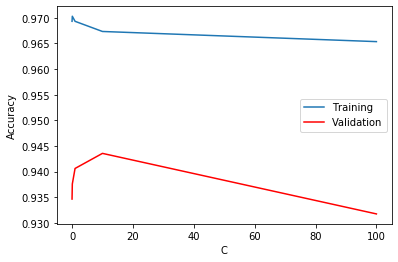

Our optimal C is 10.000000


In [27]:
# Try testing and plot
from sklearn.model_selection import cross_val_score

c_list = [0.01, 0.1, 1, 10, 100]
c_index = [0.01, 0.1, 1, 10, 100]

cv_scores_t = []
cv_scores_v = []

for c_score in c_list:
    lm = LogisticRegression(C = c_score,  solver = 'newton-cg')
    lm.fit(X_train, y_train)
    y_hat = lm.predict(X_train)
    cv_scores_t.append(cross_val_score(lm, X_train, y_hat, cv = 5, scoring = 'accuracy').mean())
    y_hat = lm.predict(X_valid)
    cv_scores_v.append(cross_val_score(lm, X_valid, y_hat, cv = 5, scoring = 'accuracy').mean())

plt.plot(c_index, cv_scores_t, label = 'Training')
plt.plot(c_index, cv_scores_v, color = 'red', label = 'Validation')
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print("Our optimal C is %f" %c_list[np.argmax(cv_scores_v)]) 

In [28]:
# Use the best parameter pair in our testing set.

LGmodel5 = LogisticRegression(solver = 'newton-cg', C=10)
LGmodel5.fit(X_train_valid, y_train_valid)

y_hat9 = LGmodel5.predict(X_test)

In [29]:
# Get accuracy score, f1 score, and time spend to run the model

accuracy9 = accuracy_score(y_test, y_hat9)
print("The accuracy score for Model 9 is: "+ str(accuracy9))

f1score9 = f1_score(y_test, y_hat9, average='macro')
print("The f1 score for Model 9 is: "+ str(f1score9))

end = time.time()
time9=end-start
print("Total time we use is: "+str(time9))

The accuracy score for Model 9 is: 0.96
The f1 score for Model 9 is: 0.958894128275554
Total time we use is: 65.75843143463135


#### Model 10: KNN 

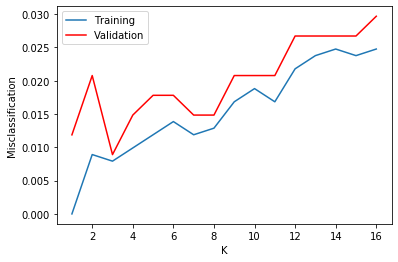

In [30]:
# Logistic Regression with original data set

start = time.time()

# Try testing and plot

train_notaccuracy = []
valid_notaccuracy = []

for k in range(1, 17):
    knn = neighbors.KNeighborsClassifier(n_neighbors = k, weights='uniform')
    knn.fit(X_train, y_train)

    y_hat = knn.predict(X_train)
    train_notaccuracy.append(sum(y_hat != y_train)/len(y_train))
    y_hat = knn.predict(X_valid)
    valid_notaccuracy.append(sum(y_hat != y_valid)/len(y_valid))

plt.plot(range(1, 17), train_notaccuracy, label = 'Training')
plt.plot(range(1, 17), valid_notaccuracy, color = 'red', label = 'Validation')
plt.xlabel("K")
plt.ylabel("Misclassification")
plt.legend()
plt.show()

In [31]:
# Get the best K value for this method
bestK = np.argmin(valid_notaccuracy)+1 # Notice here we use argmin, for the minimum error
print(bestK)

3


In [32]:
# Use the best parameter pair in our testing set.

KNNmodel5 = neighbors.KNeighborsClassifier(weights='uniform', n_neighbors=bestK)
KNNmodel5.fit(X_train_valid, y_train_valid)

y_hat10 = KNNmodel5.predict(X_test)

In [33]:
# Get accuracy score, f1 score, and time spend to run the model

accuracy10 = accuracy_score(y_test, y_hat10)
print("The accuracy score for Model 10 is: "+ str(accuracy10))

f1score10 = f1_score(y_test, y_hat10, average='macro')
print("The f1 score for Model 10 is: "+ str(f1score10))

end = time.time()
time10=end-start
print("Total time we use is: "+str(time10))

The accuracy score for Model 10 is: 0.98
The f1 score for Model 10 is: 0.979809145523082
Total time we use is: 3.520050287246704


Model 10 (KNN) is the best model for this assignment. It has the highest accuracy score, highest f1 score and lowest running time. Using the original data will give us a better result. Base on my understand, the reason KNN and Logistical Regression with original data perform better is because the prediction will be more accurate with high dimential data. Because from the paper, it showed SVM did the best job, and I think SVM maps data into a high dimential space. 

#### Thank you